# Title to go here

### Rajen Parekh and Dr. Yair Shenfeld

## 1. Environment Setup Instructions (macOS / Linux)

Follow the instructions below to create a virtual environment, install required packages, and register the notebook kernel.

Open a terminal and run the following commands:

```bash
cd /path to the mnk_transformer folder
chmod +x setup.sh
./setup.sh
```

This will set up a virtual enviroment to run the notebook in.


After the script finishes...
1. Reopen this notebook.
2. In the top-right corner, click the kernel selector (symbol shown below).
3. Choose the kernel named: `Python (TicTacToe)`

<img src="inserted_images/kernel_button.png" width=30>  ⬅️ Kernel Selector

Then, run the cell below, and you’re ready to run and read through the notebook!

In [1]:
from play_against_gpt import play_game
from functions_for_thesis_display import display_random_training_run
from setup import load_from_checkpoint
model = load_from_checkpoint()

## 2. Introduction

### Introduction to GPTs

In recent years, ChatGPT and other similar language models have become widespread. Their main goal is to generate coherent and relevant sentences, and they've gotten pretty good at it. But how does these models actually learn and work? There aren’t strict, universal rules of the English language that can be easily programmed and given to the models. Instead, very abstractly, language models learn by seeing many examples of English text and use these examples to predict the most likely next word in a sequence.

So, how can we get a better sense of how language models learn the task of next word prediction? One approach is to look at a super simple example that does have clear, well-defined rules: tic-tac-toe.

### Motivation

[Phillip Haeusler](https://philliphaeusler.com/posts/tic_tac_toe/) created and wrote a blog post about Tic Tac Transformer, a GPT model trained to play tic-tac-toe that followed Andrej Karpathy's [NanoGPT](https://www.youtube.com/watch?v=kCc8FmEb1nY) architecture. Of course, this is a terrible way to build a good tic-tac-toe bot. The game is so simple we could just explicitly program the best move in each state. But, we're not really intersted in playing tic-tac-toe well. Instead, we can use this model as a tool to learn about language models. In this setup, a move is like a word, and a game is like a sentence. Just as a sentence is built word by word, a game unfolds move by move—and in both cases, each element depends on what came before it. A string of moves must obey the rules of the game to make sense, just like a sentence must follow grammar and meaning to be coherent. Playing a valid game is equivalent to writing a grammatically correct sentence. Playing an optimal game? That’s Shakespeare.<sup>[1]</sup>

Tic-tac-toe is especially useful for this kind of exploration because it is interpretable and simple enough that we can analyze the model’s behavior move by move. Because of this simplicity and interpretabilty, we can use a GPT-style model similar to Tic Tac Transformer trained on tic-tac-toe games to explore three core questions:

- Does the model generate novel games, or simply memorize the training data?
- How does the model learn over time?
- Does it form an internal representation of the game state?

The goal of this thesis is to investigate these questions by running a series of experiments and using interpretability techniques to analyze the model’s behavior. We introduce each experiment it becomes relevant throughout the thesis, using them to isolate different aspects of how the model learns and internalizes the structure of the game. Together, these approaches help reveal how a small GPT learns to play, understand, and make sense of a simple game.

<p><sup>[1]</sup> <small><em>And something we don't focus on in this project. GPTs generally have pretraining and finetuning stages. This project focuses on pretraining, but learning to play optimally is a finetuning task.</em></small></p>

## 3. Model Representation, Architecture, and Training
Before we start discussing our experiments and results, this section provides a relatively abstract description of how the model works. We present information on how data generated and given to the model, the model's architecture, and how the model makes predictions and trains. For a full mathematical description, refer to the appendix.


### Tokenization
We talked about how tic-tac-toe can be seen as a language with moves as its words, but how do we provide this language to our GPT? Large language models like ChatGPT process language by assigning a unique number to each word in the English language in a process called *tokenization*.<sup>[1]</sup> Each number assigned to a word is a *token* . The model then treats the task of generating words as a classification problem: given a sequence of tokens, what is the most likely next token?

<p><sup>[1]</sup> <small><em>Actually, tokenization happens on parts of the English language smaller than words, called subwords. These subwords might be whole words, word stems, or even individual characters, and it also includes numbers, punctuation, and special characters. But, for our purposes, it's simple and accurate enough to think of them as words.</em></small></p>

We mirror this setup in tic-tac-toe by assigning a token to each space on the board, and starting our indexing at zero (because it's computer science). The indexing of the spaces is shown below:

<img src="inserted_images/empty_board.png" width=250>

In addition to the nine board positions, we introduce two special tokens:
- `9` is a start token, placed at the beginning of every game.
- `10` is a padding token, used to pad the game sequence once it's over but the board isn’t yet full. Padding allows us to ensure that every game sequence has the same fixed length for training.

With these eleven tokens, we can represent every game of tic-tac-toe as a list of 10 tokens. Importantly, the tokens don't specify which players made each move. As humans who know the rules of the game, we know that Player A and Player B alternate moves, but the model sees only the sequence of moves, and must implicitly learn this alternation structure during training.

Let's go over an example to clarify. Every game starts with a sequence of `[9]`, and the board looks like the empty board we saw earlier:

<img src="inserted_images/empty_board.png" width=250>

Then, after a few moves have been played, yielding a sequence of `[9, 6, 4, 2, 8, 0]`, we have a board like this:

<img src="inserted_images/half_game.png" width=250>

And finally, when the game ends before the board is full, the rest of the sequence is filled with padding tokens. For example, finishing the game above gives the sequence `[9, 6, 4, 2, 8, 0, 3, 1, 10, 10]` and this board:

<img src="inserted_images/finished_game.png" width=250>

Notice how the sequence length of the completed game is 10, even though the board isn't full? That's because Player A won early, and we used padding tokens to ensure the game sequence was the correct length.

### Generation of example games
To produce examples of games that our GPT could train and test on, we followed the following procedure to build tokenized games:

$$
\begin{array}{ll}
\text{Initialize:} \\
\quad \texttt{game} \leftarrow [\texttt{9}] \quad \text{(the start token)} \\
\quad \texttt{valid\_moves} \leftarrow \{\texttt{0}, \texttt{1}, \texttt{2}, \texttt{3}, \texttt{4}, \texttt{5}, \texttt{6}, \texttt{7}, \texttt{8}\} \\[1ex]

\text{While the game is not over:} \\
\quad \texttt{move} \leftarrow \text{random choice from } \texttt{valid\_moves} \\
\quad \texttt{game.append(move)} \\
\quad \texttt{valid\_moves.remove(move)} \\
\quad \text{Check if there is a winner or the board is full and break loop if so} \\[1ex]

\text{Pad the game to length 10:} \\
\quad \text{While } \texttt{len(game)} < \texttt{10}: \\
\quad\quad \texttt{game.append(10)} \quad \text{(the padding token)}
\end{array}
$$

This resulted in games between players who play without strategy but always play a valid move. This behavior of randomly selecting a valid move is what we want our GPT to learn.


### Model Architecture
Karpathy's NanoGPT, whose architecture 

We found that the architecture that Haeusler presented (1 transformer layer, 1 attention head, and 12-dimensional embeddings) was the simplest architecture that was able to learn how to play. This architecture is what is used throughout this project unless stated otherwise.
### Loss Function and Training
Describe what the loss function is and how many training iterations, weights updated with backprop

can use each triaining example many times. Look at move 1 for move 2 pred, move 1+2 for move 3 pred, etc.

## 4. Answering our Research Questions

### Model Success
First, let's confirm that the model works. This wouldn't be much of a thesis if it didn't, but test it out below. Keep in mind, the model's goal is to play a legal move, not to play *well*, so you should be able to win pretty easily, but note how it plays by the rules. Click play on the cell below and interact with the buttons to play against the model. *How* does this model learn? Well, that's what we'll discuss in the rest of this document.

In [2]:
play_game(model)

### Model Originality

We've seen above that the trained model can successfully play a game of tic-tac-toe. But how does it do that? Might it just be memorizing the games we showed it as it trained, and repeating them back exactly? This would be bad, especially when we think about language models! What if ChatGPT could only regurgitate exact writing that it had seen before? These models are only useful if they can generate novel games (or text!), so we test this capability.

To test the model's creativity, we train the model on 100,000 synthetically generated games of tic-tac-toe.<sup>[1]</sup> These games are created by randomly choosing a move for players until one player wins or the board is filled. After training, we have the model generate 1,000 games and measure how many of them appeared in the training set.

$$
\text{Originality Score} = 1 - \frac{\text{\# of generated games present in training dataset}}{\text{total \# of games generated}}
$$

There are 255,168 possible games of Tic-Tac-Toe, so we would expect originality scores around<sup>[2]</sup>

$$
\frac{255,\!168 - 100,\!000}{255,\!168} \approx 60.8\%
$$

Across 100 training trials (61 of which learned to play successfully before 100k iterations, which we'll call the models that "converged" later on), the mean originality score was 58.1%. So, the model is able to generate unseen game sequences at approximately the rate we'd expect.<sup>[3]</sup> It is not memorizing, but instead seems to be learning the rules of the game and generating games it has never seen before! We'll explore how it does that in the following section...

<p><sup>[1]</sup> <small><em>The model architecture is detailed in the appendix. These models were trained with 1 transformer layer, 1 attention head, and a 12-dimensional embedding.</em></small></p>

<p><sup>[2]</sup> <small><em>We would actually expect an originality score slightly higher than 60.8%, because the synthetic games are randomly generated, and can include overlapping games. A dataset with 100,000 elements is highly unlikely to have 100,000 distinct elements, but this is an expected floor for our originality score.</em></small></p>

<p><sup>[3]</sup> <small><em>This value is slightly smaller than the rate we'd expect! I think this is happening because some of the 255,168 games are more likely to occur when creating the synthetic dataset. For example, to match a short game when P1 wins quickly, only five moves need to match, but to match a long game, nine moves need to match. This means the short games are more likely to be generated synthetically (and be in our training data), and are more likely to be generated by any model that selects between moves randomly. This should drive originality scores down!</em></small></p>


### Learning the Rules of the Game
What are the rules of tic-tac-toe? Without thinking about any strategy, we can define two things a player needs to do in order to play by the rules:

1. Pick a space that neither player has played in before to place their token. A space can't be occupied by multiple tokens, and if a player tries to play on top of another token, a mistake has been made!

2. Three tokens in a row wins the game. If the game is over and a player tries to play, or the game is not over and a player states that it is, a mistake has been made!

**Keep these rules in mind!** They'll be very important for the rest of this document!

Let's take a closer look at the 62 training trials that learned to play successfully to see how these models might be learning the two rules stated above! Plotted below is the validation loss by iteration for each of the trials.<sup>[1]</sup> The graph is a little messy since there are so many trials shown, but run the next cell and take a look and see if you notice a trend!

<p><sup>[1]</sup> <small><em>We use categorical cross-entropy loss. The calculation of this loss is defined in the model architecture and training section.</em></small></p>

<img src="inserted_images/converging_runs.png" width=1000>

Notice how many trials stall with a validation loss between 1.36 and 1.37? In fact, >70% of the runs that converge exhibit this stalling behavior for at least 5,000 iterations. Let's take a closer look at them and see what's going on!

We'll define two new statistics to measure how well a model understands the rules...
1. Invalid Move Rate: This measures how often the model generates a move that has been previously played in the game sequence. It is computed over all generated games (rather than all generated moves), so if a game has any invalid move, it counted towards the invalid rate. It is calculated as follows:

$$
\text{Invalid Move Rate} = \frac{\text{\# of generated games with an occupied space generated}}{\text{Total \# of generated games}}
$$

2. Correct Ending Rate: This measures how often the model predicts that the padding token will be the next token when given a game with a winner. In the training data, whenever a game ends before 9 moves (meaning a player has won before the board is full), the game sequence contains padding tokens to preserve the full sequence length. Once a model learns Rule 2, it should always predict the padding token when given a completed game to mirror this pattern in the training data.<sup>[1]</sup> It is calculated as follows:

$$
\text{Correct Ending Rate} = \frac{\text{\# of correct padding predictions after a win}}{\text{\# of generated games resulting in either player winning}}
$$

Run the cell below to randomly select one of the trials that exhibited this stalling behavior. Notice the pattern between the validation loss (rescaled to fit on the same axes), the invalid move rate, and the correct ending rate.

<p><sup>[1]</sup> <small><em>I actually made a small mistake while running tests, and only tested identifying the padding token on non-full boards (games that ended in 8 moves or less). I didn't have time to fully re-run the experiments, but from a few trials to confirm that performance was the same, I saw no difference in results. </em></small></p>

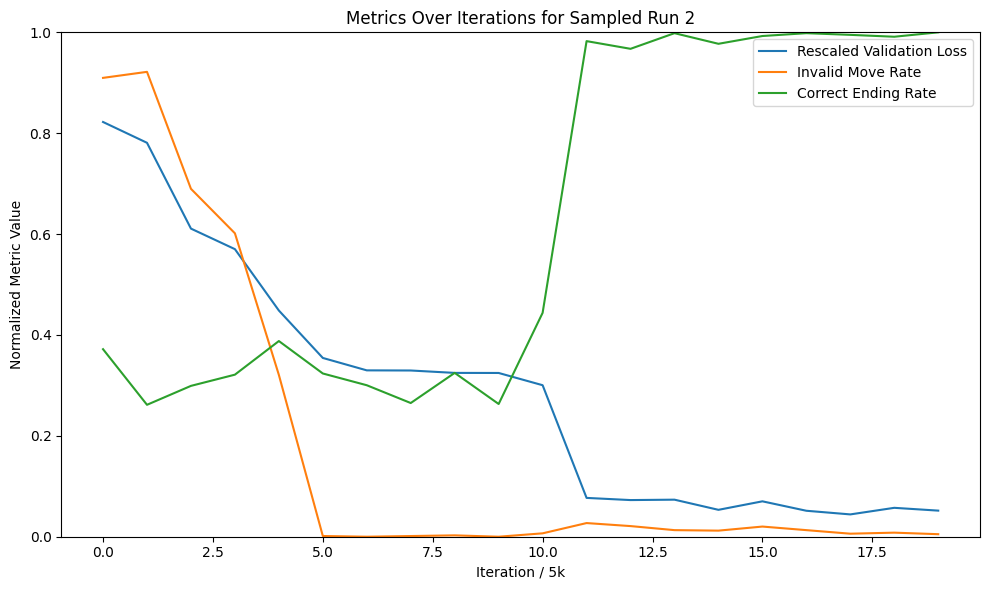

In [3]:
display_random_training_run()

The first thing to note is that, in all of these trials, the correct ending rate approaches 1 and the invalid move rate approaches 0 by the end of training. This means that by the end of training, the model successfully learns the rules of tic-tac-toe! It can avoid playing in occupied spaces and identifies when the game has been won.

Next, observe that the validation loss drops in two stages. During the first one, the invalid move rate drops nearly to 0, but the correct ending rate stagnates and/or fluctuates randomly, showing no improvement. Then, during the second drop, the invalid move rate increases slightly while the correct ending rate drastically increases. As training finishes, the correct ending rate gets even higher, and the invalid move rate slowly decreases back towards 0. This trend holds for all of the trials that stall with a loss between 1.36 and 1.37 for at least 5,000 iterations. Keep hitting play on the cell above to randomly select more trials and confirm this trend.

Clearly, the model seems to be learning the two rules of tic-tac-toe separately, first learning to play in unoccupied spaces and next learning to identify winners, but what is going on internally when this happens? *How* does this learning occur?

### Internal Game Representation

#### Background Work
A [research team from Harvard, MIT, and Northeastern](https://arxiv.org/abs/2210.13382) created a model called OthelloGPT, which was a GPT trained to generate games of Othello, another simple board game. Like our tic-tac-toe GPT, it was able to generate valid moves with very few errors. This team's central question was whether OthelloGPT had learned an internal representation of the game state without knowledge of the rules of the game.

To study this, they introduced *probes*:classifiers trained to predict the state of each space on the board (empty, Player 1, or Player 2) from the model’s internal activations after being given a sequence of moves. For each layer, they created a dataset by pairing the activations at that layer with the board state implied by the input sequence that produced them. This allowed them to evaluate what information about the board was encoded at different depths of the model.

They compared probes trained on a randomly initialized model with probes trained on a fully trained model. On the untrained model, both linear and nonlinear probes performed poorly, showing that the probes themselves were not powerful enough to extract board state from random transformations of the input sequence. On the trained model, however, a nonlinear probe was able to recover the full board state with up to 98% accuracy. This is notable because it shows that during training, OthelloGPT developed an internal representation of the game state, *even though it was never explicitly told the rules of the game, and was only asked to predict the next move*. The linear probe, by contrast, still struggled, performing only slightly better on the trained model than on the untrained model. This suggests that the learned representation was  nonlinear and not directly accessible with a simple linear decoder.

However, [Neel Nanda](https://www.neelnanda.io/mechanistic-interpretability/othello) further investigated the internal game representation of OthelloGPT. Instead of training the probe to classify a space as Player 1/Player 2/Empty, he modified the task to classify a space as "Mine"/"Opponent's"/Empty. With this modified task, he found that a linear probe was able to reconstruct the board state! 

Here's what this other approach looks like for tic-tac-toe:
Say we have input sequence [9, 2, 5, 3, 4, 0]. Recall from the model architecture section that 9 is the start token, and the remaining tokens indicate where Player 1 and Player 2 place their alternating moves. In a Player 1/Player 2 representation, the board unsurprisingly looks as follows:

<img src="inserted_images/p1_p2_board.png" width=250>

But, in a "Mine"/"Opponent's" system, the current player is Player 2! So Player 2's tokens are counted as "Mine" and Player 1's are counted as "Other":

<img src="inserted_images/me_opp_board.png" width=250>

Now, observe what happens when we add another move to the game, making our input sequence [9, 2, 5, 3, 4, 0, 7]. The original moves on the P1/P2 board are unchanged:

<img src="inserted_images/p1_p2_board_update.png" width=250>

But, the original moves on the Mine/Opponent's board have flipped, because the current player is now Player 1!

<img src="inserted_images/me_opp_board_update.png" width=250>

We'll use this modified task later on!


#### Our Questions
Based on these two studies of OthelloGPT, we attempt to apply a version of probing to our model. Our main goal is to understand more about two-stage learning the model exhibits, and to do so, we ask three questions:
1. Does our model learn an internal representation of the board state, like OthelloGPT?
2. Is this representation linear or nonlinear?
3. How does the internal representation change when the model is at different stages of the training process? And specifically, what happens when validation loss first reaches the 1.36-1.37 range, and what happens when it leaves that range?

#### Different Tasks to Test
To learn more about our model's behavior, we define four tasks to test our probe on. Tasks 1 and 2 directly mirror Rule 1 and Rule 2 of tic-tac-toe, which we defined above. Tasks 3 and 4 relate to the identity of the player occupying each space and allow us to directly compare the classification tasks of the original Othello paper and Nanda's update. Together, these tasks let us examine different aspects of the model’s internal understanding of the game. The tasks are defined below:

1. What spaces are occupied?
2. Has the game been won?
3. Which player has played in each space, using Player 1's vs Player 2's space
4. Which player has played in each space, using "My" vs "Opponent's" space


#### Different Probe Architectures
We also want to be sure that if there are differences in performance between linear and nonlinear probes, this difference is due to the nonlinearity of the internal representation, not just that nonlinear probes have more parameters and are more powerful. <sup>[1]</sup> In order to test this, we use three probes: a linear probe, a small MLP, and a large MLP. The number of parameters for each model and task are shown in the table below:<sup>[2]</sup>

|              | Task 1 | Task 2 | Task 3 | Task 4 |
|--------------|--------|--------|--------|--------|
| Linear       |    351    |    26    |   351     |     351   |
| Small MLP    |   507     |     182   |    507    |   507     |
| Large MLP    |   1403     |    978    |   1403     |    1403    |

For most tasks, the small MLP is closer in number of parameters to the linear model than it is to the large MLP. This means that if we see a large performance gap between the linear model and the small MLP, but a small performance gap between the small MLP and the large MLP, we can probably attribute the difference to an inherently nonlinear representation, not a more complex probe. 

<p><sup>[1]</sup> <small><em>The size of the linear vs. nonlinear probes is actually not mentioned in the original Othello paper, so this is especially important to test! </em></small></p>

<p><sup>[2]</sup> <small><em>Exact probe architecture is detailed in the appendix. </em></small></p>



#### Results Part 1: Internal Representation Existence and Linearity
In order to train the probes on activation-board pairs, we need to train a GPT to generate these pairs. The training run for the GPT used to generate probing data is displayed below.<sup>[1]</sup> Circled locations are where checkpoints were taken. From left to right Checkpoint 1 is an untrained and randomly initialized model, Checkpoint 2 is the model when validation loss first reaches 1.37, Checkpoint 3 is the model when validation loss first reaches 1.36, and Checkpoint 4 is the model after 100,000 iterations.

<p><sup>[1]</sup> <small><em>As a reminder, these models have 12 embeddings, 1 attention head, and 1 transformer layer. </em></small></p>

<img src="inserted_images/checkpoint_locs.png" width=500>

To generate data, we begin by loading the trained GPT model at each of the four checkpoints. We use a dataset consisting of full tic-tac-toe games, each encoded as a sequence of tokens as discussed in the Model Representation section [TODO: WRITE THIS]. These sequences represent complete games, but we do not feed the entire sequence to the model all at once. Instead, for each game, we create a series of 10 truncated input sequences: the first contains only the start token, the second contains the start token followed by the first move, the third includes the first two moves, and so on, up to the full sequence of 10 tokens. This results in 10 distinct input sequences per game, each representing a partial progression of the game state.

Each of these input sequences is fed through the model, and we extract the corresponding internal activations after each layer of the model: (1) the embedding layer, (2) the  transformer block, and (3) the final MLP layer. These activations constitute the input features used to train the probing models.

The corresponding ground truth labels are derived directly from the input sequences by decoding the tokenized moves to reconstruct the board state at that point in the game. Depending on the specific probing task, the label is either (a) a classification for each of the 9 spaces on the board (e.g., predicting whether a space is X, O, or empty), or (b) a binary label indicating whether the board has a winner. This procedure is repeated independently for each checkpoint, enabling us to compare how the internal representations evolve over the course of training.

Once the probing data is generated, we are left with a distinct dataset for each combination of checkpoint and layer... one for the embedding layer, one for the first transformer block, and one for the final activation layer, at each of the four checkpoints. Each of these datasets is split into a training set of 100,000 examples and a validation set of 20,000 examples. We train a separate probe on the training portion of each dataset and evaluate it on the corresponding validation set. For Task 1, Task 3, and Task 4, we compute space accuracy, defined as the percentage of individual board spaces the probe correctly classifies. For Task 2, we compute board-level accuracy, which measures how often the probe correctly determines whether or not the board contains a winner.

Results of this experiment are shown in tables below. In this section, we'll focus on whether there is an internal representation, whether it is linear, and where within the model this representation is learned. The results compare four probes: a linear, a small MLP, and a large MLP using data from Checkpoint 4 (when the model has fully trained) and a large MLP using data from Checkpoint 1. Because Checkpoint 1 is a randomly initialized model, this large MLP serves as a baseline of how well the most powerful probe can do using activations from an untrained model. We can compare the other three probes trained on Checkpoint 4 data to this baseline to understand how much the GPT's internal representation improves during training.


#### Task 1: What spaces are occupied?

| Probe Type                | Layer 1 | Layer 2 | Layer 3 |
|----------------------|---------|---------|---------|
| Linear               | 0.774   | 0.936   | 0.943   |
| Small MLP            | 0.788   | 0.953   | 0.973   |
| Large MLP            | 0.788   | 0.977   | 0.988   |
| Large MLP (Baseline)| 0.760   | 0.764   | 0.829   |

**1. Is there an internal representation?**  
Yes! By Layer 3, all three probes trained on Checkpoint 4 greatly outperform the baseline probe. This suggests the GPT learns an internal representation of space occupancy.

**2. Where is this representation learned?**  
It seems to be mostly learned by Layer 2, the transformer layer. This is where we see probe accuracy spike.

**3. Is this representation linear?**  
Likely! The linear probe is able to make predictions that are nearly as accurate as either of the MLP probes. The nonlinear probes do slightly outperform the linear probe, so there might be some nonlinearity in the representation.
 



#### Task 2: Has the game been won?

| Probe Type                 | Layer 1 | Layer 2 | Layer 3 |
|----------------------|---------|---------|---------|
| Linear               | 0.924   | 0.919   | 0.954   |
| Small MLP            | 0.925   | 0.986   | 0.986   |
| Large MLP            | 0.922   | 0.987   | 0.988   |
| Large MLP (Baseline)| 0.912   | 0.922   | 0.924   |

**1. Is there an internal representation?**  
Yes! By Layer 3, all three probes trained on Checkpoint 4 greatly outperform the baseline probe. This suggests the GPT learns an internal representation of whether the game has been won.

**2. Where is this representation learned?**  
The MLP probes learn this representation by Layer 2, the transformer layer. However, the linear probe only achieves accuracy above baseline at Layer 3, the GPT's MLP layer.

**3. Is this representation linear?**  
Somewhat! The MLP probes perform similarly to each other, and far outperform the linear probe, but the linear probe does substantially outperform the baselie probe. The fact that the MLP probes learn the internal represenation before Layer 3, while the linear probe does not, suggests that the GPT's MLP layer removes some, but not all, of the nonlinearity of the representation.




#### Task 3: Which player has played in each space? (P1 vs P2)
| Probe Type                | Layer 1 | Layer 2 | Layer 3 |
|----------------------|---------|---------|---------|
| Linear               | 0.609   | 0.729   | 0.732   |
| Small MLP            | 0.620   | 0.783   | 0.778   |
| Large MLP            | 0.665   | 0.796   | 0.798   |
| Large MLP (Baseline)| 0.663   | 0.674   | 0.698   |

**1. Is there an internal representation?**  
Yes! By Layer 3, both MLP probes trained on Checkpoint 4 greatly outperform the baseline probe, and the linear probe slightly outperforms baseline. This suggests the GPT learns an internal representation of space occupancy from a P1-P2 perspective.

**2. Where is this representation learned?**  
All three probes learn this representation by Layer 2, the transformer layer. Layer 3 does not further increase probe accuracy.

**3. Is this representation linear?**  
No! The MLP probes perform similarly to each other, and far outperform the linear probe. The linear probe does perform better than baseline, but not substantially so.




#### Task 4: Which player has played in each space? (Mine vs Opponent)

| Probe Type            | Layer 1 | Layer 2 | Layer 3 |
|----------------------|---------|---------|---------|
| Linear               | 0.642   | 0.768   | 0.833   |
| Small MLP            | 0.668   | 0.877   | 0.871   |
| Large MLP            | 0.670   | 0.900   | 0.901   |
| Large MLP (Baseline)| 0.667   | 0.637   | 0.697   |

**1. Is there an internal representation?**  
Yes! By Layer 3, all three probes trained on Checkpoint 4 greatly outperform the baseline probe. This suggests the GPT learns an internal representation of space occupancy from a mine-yours perspective.

**2. Where is this representation learned?**  
The MLP probes learn this representation by Layer 2, the transformer layer. The linear probe achieves accuracy over baseline by Layer 2, but is substantially more accurate after Layer 3.

**3. Is this representation linear?**  
Somewhat! The MLP probes perform similarly to each other, and far outperform the linear probe. The linear model does, however, perform substantially better than baseline. The increase in the linear probe's performacne between Layer 2 and Layer 3 suggests that the GPT's MLP layer removes some nonlinearity from its internal representation.


##### Overall summary
The success of the probes suggests the GPT model develops internal representations for each task, even though it was not explicitly trained to do so. These representations are largely formed in the transformer layer (Layer 2), with the MLP layer (Layer 3) often refining them and making them more accessible to linear probes. In Tasks 1, 3, and 4, we see a noticeable spike in accuracy for all probe types at Layer 2, indicating that the transformer layer encodes information relevant to these internal representations. In Tasks 2 and 4, the MLP layer further boosts linear probe performance, suggesting that it helps transform these nonlinear representations that the transformer produces into a more linearly decodable form. 

While linear probes consistently outperform the baseline, they are typically outperformed by both the small and large MLP probes. This pattern, observed across all tasks, suggests that the internal representations are only partially linear.

Tasks 3 and 4 mirror the tasks tested by the OthelloGPT team (Task 3) and Nanda (Task 4). Consistent with Nanda's work, all probe types perform better on the "mine" vs "opponent" task than on the "P1 vs P2" task. This supports the idea that the model interprets and represents the board from the perspective of the *current player*. However, our results diverge from Nanda’s in a key way: while Nanda concluded that Task 4 could be fully represented with a linear probe, we find that the nonlinear probes still substantially outperform the linear probe in this setting. This indicates that the GPT's internal representation of the "mine" vs "opponent" task is still meaningfully nonlinear. This result aligns more closely with conclusions from the OthelloGPT team, who found that nonlinear probes are needed to access the model’s internal board state representations.


#### Results Part 2: Changes in Internal Representation During Training
Now that we know that the GPT eventually learns an internal represenation of the game state, we'll explore how this representation develops as the model trains. Recall the two rules we defined for tic-tac-toe. In particular, we observed that the GPT first learns to not play in occupied spaces (Rule 1) at Checkpoint 2, and later learns to correctly identify the end of games (Rule 2) at Checkpoint 3. Is this because it has different internal representations at these checkpoints? How do the internal represenations change during training?

We test this by comparing the performance of each probe type (Linear, Small MLP, Large MLP) on our four tasks across checkpoints. Task 1 explicitly tests model understanding of Rule 1 and Task 2 explicity tests model understanding of Rule 2. Task 3 and 4 involve understanding and representing the entire board state, so they require an understanding of Rule 1 and Rule 2.

Presented below are tables for the accuracies of probes trained on each checkpoint after the Layer 3 of the GPT, as well as a chart showing how each probe's performance changes across checkpoints. We'll discuss the results below.
#### Linear Probe

| Task     | Checkpoint 1 | Checkpoint 2 | Checkpoint 3 | Checkpoint 4 |
|----------|--------------|--------------|--------------|--------------|
| Task 1   | 0.660        | 0.948        | 0.932        | 0.943        |
| Task 2   | 0.900        | 0.920        | 0.954        | 0.954        |
| Task 3   | 0.569        | 0.745        | 0.734        | 0.732        |
| Task 4   | 0.587        | 0.750        | 0.824        | 0.833        |

#### Small MLP Probe

| Task     | Checkpoint 1 | Checkpoint 2 | Checkpoint 3 | Checkpoint 4 |
|----------|--------------|--------------|--------------|--------------|
| Task 1   | 0.790        | 0.979        | 0.960        | 0.973        |
| Task 2   | 0.923        | 0.921        | 0.987        | 0.986        |
| Task 3   | 0.649        | 0.769        | 0.755        | 0.778        |
| Task 4   | 0.661        | 0.772        | 0.855        | 0.871        |

#### Large MLP Probe

| Task     | Checkpoint 1 | Checkpoint 2 | Checkpoint 3 | Checkpoint 4 |
|----------|--------------|--------------|--------------|--------------|
| Task 1   | 0.829        | 0.991        | 0.970        | 0.988        |
| Task 2   | 0.924        | 0.922        | 0.988        | 0.988        |
| Task 3   | 0.698        | 0.779        | 0.778        | 0.798        |
| Task 4   | 0.697        | 0.792        | 0.879        | 0.901        |

#### Results Plotted

<img src="inserted_images/accuracy_by_checkpoint.png" width=1000>

#### Observations

Take a look at the tables and chart above, and focus on the transition between Checkpoint 2 and Checkpoint 3. As we discussed, this is where the GPT's behavior shifts. At Checkpoint 2, the model has learned not to play invalid moves but cannot identify when the game has ended (invalid move rate is low, but correct ending rate is also low), but at Checkpoint 3, it learns to identify when games have ended (the correct ending rate is now high) . This progression aligns with our two defined rules of tic-tac-toe. Task 1 (Rule 1) and Task 2 (Rule 2) help isolate the internal representation of each rule, while Tasks 3 and 4 depend on a composition of both.

By Checkpoint 2, Task 1 performance is already nearly perfect for all probe types, especially for the nonlinear probes. This suggests that an internal representation of occupied spaces is well established by this point in training. In contrast, performance on Task 2 does not improve until Checkpoint 3, where it jumps to nearly perfect performance, especially for the MLP probes. This shift in Task 2 accuracy mirrors the point at which the GPT starts identifying game ends correctly, suggesting that the internal representation of Rule 2 is not present until this later checkpoint.

Tasks 3 and 4 both require an understanding of both Rule 1 and Rule 2, but they show different patterns. Probes trained on Task 3 see a jump from Checkpoint 1 to 2, then plateaus. Task 4, on the other hand, shows consistent improvement across all checkpoints. This suggests that [WHAT DOES THIS SUGGEST?]

Taken together, these results highlight that the GPT's internal representation of game state evolves in distinct phases. First, it learns to represent occupied spaces (Rule 1) by Checkpoint 1, then it incorporates signals for game termination (Rule 2) by Checkpoint 2. Importantly, the probes help us understand not just *that* the model behaves differently, but *why* it performs differently, by revealing when different understandings of the board state become represented internally by the model. The probing tasks allow us to track these representational changes over time, and the difference in probe performance between Checkpoints 2 and 3 offers strong evidence that the changes in model behavior we observed reflect changes in the model’s internal encoding of the game. While the model could in theory behave correctly without any internal representation of the game, the probes show that such a representation does, in fact, emerge and evolve over training.


#### Changing the Number of Attention Heads

### TODO: FILL IN THIS SECTION ONCE I HAVE PROBE RESULTS
Present results from the two-headed model. Instead of learning staggered, it learns simultaneously. Could each head be focusing on one of the rules?

<img src="inserted_images/probing_trial_2h.png" width=500> 
<img src="inserted_images/converging_2_heads.png" width=500> 
Discuss...
1. This model training is smooth, not staggered. Show other train trials with this architecture and note how many of them would qualify as staggered by our first definition
2. display results and show not a large jump between ckpt 2 and 3, instead sustained learning
3. Propose that the different attention heads might be learning different tasks

## 5. Conclusion

### Summary of Findings
In this project, we trained a GPT to generate valid moves and complete games of tic-tac-toe. We were interested in three main questions:

1. Does the model generate novel games, or just memorize games that it was shown?
2. How does this learning occur?
3. Is there an internal representation of the game? Does it change as the model learns?

To answer the first question, we looked at the full games the model generated and observed what proportion of those were included in the training dataset, and what proportion were original. We found that the model generated original games at around the frequency we'd expect of a model without any memorization, so we concluded that the model was not memorizing, but instead was learning to play tic-tac-toe legally.

To address the second question, we tracked how the model learned over time. In more than 70% of successful training runs, the model's loss decreases in two distinct stages. Each of these stages corresponds to one of the two rules of tic-tac-toe:
1. Play a token in an unoccupied space.
2. If one player places three of their tokens in a row, they win. 
After the first stage, the model learns to avoid illegal moves where it attempts to play in an already-occupied space (Rule 1). After the second stage, the model learns to recognize when the a player has won by occupying three spaces in a row and stops predicting additional moves, instead predicting the padding token used to signify the end of a game (Rule 2). These shifts in behavior suggest that the model somehow internalizes the basic rules of tic-tac-toe, first learning how to play legally, then learning how the game ends.

For our final question, we were interested in understanding more about how the model learns the rules of the game. To do so, we trained linear and nonlinear probes on the GPT's activations to see if the GPT developed an internal representation of the board state, and if this representation changed throughout training. We defined four probing tasks: Task 1, whether a space was occupied, and Task 2 whether there was a winner, reflected the rules of tic-tac-toe we defined earlier. Task 3 and Task 4 involved identifying which player occupied each square (with different framing) and tested understanding of the entire board. For each of these tasks, probes trained on activations from a fully trained GPT outperformed probes trained on activations from an untrained GPT, suggesting that the GPT learned an internal representation of the board. Importantly, the model was not tasked with learning this internal representation, only generating the next valid move, but the representation developed anyway. We tracked the success of the probes across layers and found that this representation was primarily learned by the transformer layer. Because nonlinear probes consistently outperformed linear probes, it seems that this representation is somewhat nonlinear. Finally, we observed that the internal representation evolved as the GPT trained, and the game state information our probes were able to extract matched the model's generation capabilities at the training stage from which the probe was generated.


### Future Work

While I'm satisfied with my findings in this project, there were a number of tasks/questions I wanted to look into, but didn't have the time to accomplish. I've detailed some avenues for future work below:

#### Generalization to *mnk* Games
Tic-tac-toe is a special case of an *mnk* game (with *m* = *n* = *k* = 3), where players alternate turns on an *m* × *n* board and aim to control *k* consecutive spaces. A natural extension of this project is to explore how the GPT learns to play these more complicated games. I was planning to go in this direction for a while before I noticed the multi-stage learning and decided to investigate that, so my codebase is set up to work with all *mnk* games. Because of that work, it shoudn't be too difficult to extend this project to more general *mnk* cases.

#### Minimum Embedding Dimensionality
As I tested different GPT architecture, I found that a minimum of 12-dimensional embeddings were necessary for the GPT to learn to play legal games. This mirrors what Haeusler found in his original creation of TicTacTransformer. However, neither Heusler nor I propose *why* 12 dimensions might be necessary. This result is especially surprising because, in theory, 11 dimensions should be sufficient to uniquely represent each token given that our vocabulary is only 11 words (all nine moves on the board, the start token, and the pad token). Further investigation to discover why 12-dimensional embeddings are necessary could help us further understand the model's learning process.

#### Interventions on Internal Representations
In addition to training probes on their model's activations, OthelloGPT team demonstrated that it is possible to causally intervene on a model’s internal representations to manipulate its behavior in predictabke ways. In their experiments, they passed in a game sequence to OthelloGPT, then edited the model's activations so that their probes would predict a different board state from the one that was inputted. Using these new activations, the model was told predict the next move. They found that the model predicted moves that were legal on the new board state inferred from the probe, not the original board state given to the model. This showed that the model’s internal representation of game state was not a byproduct of training, but instead was influential in shaping its output. 

A clear next step for this project is to perform similar interventions on our GPT. By editing the model's activations so that our probes predictd a different board state, we could test whether the model's predictions change in response. For example, if we change the activations such that a previously occupied space appears empty, and the model then chooses to place a move there, it would suggest that the model relying on its internal board representation to decide where to play. This kind of intervention would help us figure out whether the internal representations we saw with probes are actually used by the model to guide its predictions, or if they’re just a side effect of training that happen to be decodable by our probes.

## 6. Appendix

### Parameter Allocation
Describe results we found

### Probe on model with two heads
### Mechanistic Interpretability Lit Review
Todo

### GPT Math